In [2]:
#Step 1: Define function to extract features and save them into CSV
def extract_features_and_save(audio_file, sr):
    # Load audio file
    audio, sr = librosa.load(audio_file, sr=sr)
    
    # Calculate frame and hop lengths in samples
    frame_size = int(frame_length * sr)
    hop_size = int(hop_length * sr)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=frame_size, hop_length=hop_size)
    
    # Extract F0 (Fundamental Frequency)
    f0, voiced_flag, voiced_probs = librosa.pyin(audio, 
                                                 fmin=librosa.note_to_hz('C2'),  # Lowest pitch (C2 ≈ 65.41 Hz)
                                                 fmax=librosa.note_to_hz('C7'),  # Highest pitch (C7 ≈ 2093 Hz)
                                                 sr=sr, 
                                                 hop_length=hop_size)
    
    # Replace NaN values in F0 with 0 (unvoiced frames)
    f0 = np.nan_to_num(f0)
    
    # Create a DataFrame with MFCC and F0
    mfccs_transposed = mfccs.T  # Transpose so that each row represents a time segment
    f0_column = f0[:len(mfccs_transposed)]  # Ensure the F0 length matches the number of time segments
    
    # Build the DataFrame
    data = pd.DataFrame(mfccs_transposed, columns=[f"MFCC_{i}" for i in range(mfccs_transposed.shape[1])])
    data['FO'] = f0_column
 
    # Save to CSV (filename will be the name of the audio file with .csv extension)
    output_file = os.path.splitext(os.path.basename(audio_file))[0] + "_features_40.csv"
    data.to_csv(output_file, index=False)
    print(f"Features saved to {output_file}")


In [3]:
#Step 2: Extract for training data (session 1-3) for window size 40 ms with overlap 10 ms
import os
import librosa
import numpy as np
import pandas as pd

# Folder path containing audio files
audio_folder = r"IEMOCAP\IEMOCAP\Training Set"  # Update with your folder path

# Parameters for feature extraction
frame_length= 0.04 #20 ms
hop_length = 0.01  #10 ms
sr=22050

# Iterate through each audio file in the folder
for audio_file in os.listdir(audio_folder):
    if audio_file.endswith('.wav'):  # Assuming the audio files are in WAV format
        audio_path = os.path.join(audio_folder, audio_file)
        extract_features_and_save(audio_path,sr)
        
print(f"Features extraction of training dataset for window size 40 ms with overlap 10 ms for each audio files has completed.")

Features saved to Ses01F_impro01_features_40.csv
Features saved to Ses01F_impro02_features_40.csv
Features saved to Ses01F_impro03_features_40.csv
Features saved to Ses01F_impro04_features_40.csv
Features saved to Ses01F_impro05_features_40.csv
Features saved to Ses01F_impro06_features_40.csv
Features saved to Ses01F_impro07_features_40.csv
Features saved to Ses01F_script01_1_features_40.csv
Features saved to Ses01F_script01_2_features_40.csv
Features saved to Ses01F_script01_3_features_40.csv
Features saved to Ses01F_script02_1_features_40.csv
Features saved to Ses01F_script02_2_features_40.csv
Features saved to Ses01F_script03_1_features_40.csv
Features saved to Ses01F_script03_2_features_40.csv
Features saved to Ses01M_impro01_features_40.csv
Features saved to Ses01M_impro02_features_40.csv
Features saved to Ses01M_impro03_features_40.csv
Features saved to Ses01M_impro04_features_40.csv
Features saved to Ses01M_impro05_features_40.csv
Features saved to Ses01M_impro06_features_40.csv

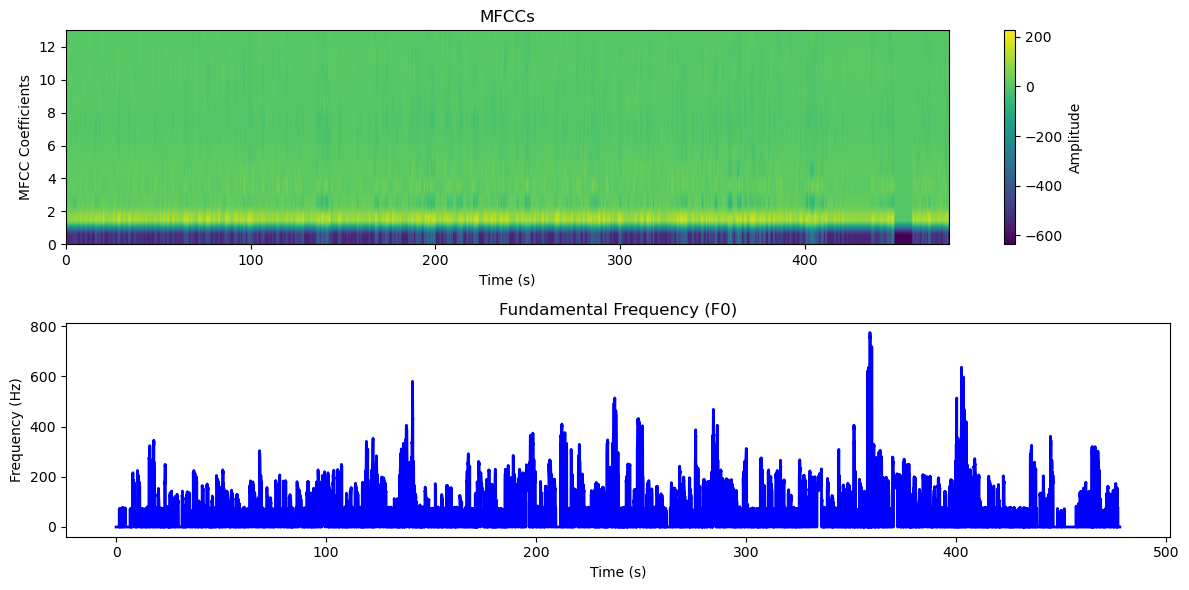

In [4]:
#Step 3: Define function to visualize MFCCs and F0 from a CSV file

import matplotlib.pyplot as plt

def visualize_features_from_csv(csv_file, hop_length, sr):
    # Load features from the CSV
    data = pd.read_csv(csv_file)
    
    # Extract MFCCs and F0
    mfccs = data[[col for col in data.columns if "MFCC_" in col]].values.T  # Transpose to match librosa format
    f0 = data['FO'].values
    
    # Calculate time axis for visualization
    num_frames = mfccs.shape[1]
    time_axis = np.arange(num_frames) * hop_length
    
    # Plot MFCCs
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(mfccs, aspect='auto', origin='lower', cmap='viridis', extent=[time_axis[0], time_axis[-1], 0, mfccs.shape[0]])
    plt.colorbar(label="Amplitude")
    plt.title("MFCCs")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")
    
    # Plot F0
    plt.subplot(2, 1, 2)
    plt.plot(time_axis[:len(f0)], f0, color='blue', linewidth=2)
    plt.title("Fundamental Frequency (F0)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Parameters for hop length and sampling rate (must match the ones used during extraction)
hop_length = 0.01  # 10 ms
sr = 22050         # Sampling rate

# File path for the sample CSV file (update with the correct path)
sample_csv_file = r"Ses01F_script01_1_features_40.csv"  # Replace with the path to the extracted CSV

# Visualize features for the sample audio file
visualize_features_from_csv(sample_csv_file, hop_length, sr)


In [5]:
#Step 4: Define function to parse RTTM file and generate labels
def parse_rttm(rttm_file, num_frames, hop_length, sr):
    rttm_data = pd.read_csv(rttm_file, delim_whitespace=True, header=None, 
                            names=["Type", "File_ID", "Channel", "Start", "Duration", "NA1", "NA2", "Speaker", "NA3", "NA4"])
    
    labels = np.zeros(num_frames)  # Initialize all labels to 0 (no speaker change)
    frame_times = np.arange(0, num_frames) * hop_length 

    for _, row in rttm_data.iterrows():
        start, duration = row["Start"], row["Duration"]
        end = start + duration
        # Mark labels for frames within the speaker's segment
        labels[(frame_times >= start) & (frame_times < end)] = 1  # 1 indicates a speaker segment
    
    return labels

In [6]:
#Step 5: Label speaker changes for training dataset 

#Folder paths
csv_folder = r"Training Extracted Features 40"  # Folder containing feature CSV files
rttm_folder = r"IEMOCAP/IEMOCAP/reference"         # Folder containing RTTM files

# Parameters
hop_length = 0.01  # Hop length used during feature extraction
sr = 22050        # Sampling rate used during feature extraction

# Process each CSV file
for csv_file in os.listdir(csv_folder):
    if csv_file.endswith('.csv'):
        csv_path = os.path.join(csv_folder, csv_file)
        rttm_file = os.path.join(rttm_folder, os.path.splitext(csv_file)[0].replace("_features_40", "") + ".rttm")
        
        if os.path.exists(rttm_file):
            # Load existing CSV file
            data = pd.read_csv(csv_path)
            
            # Number of frames (rows in the CSV)
            num_frames = data.shape[0]
            
            # Generate labels from the corresponding RTTM file
            labels = parse_rttm(rttm_file, num_frames, hop_length, sr)
            
            # Add labels to the DataFrame
            data["Label"] = labels
            
            # Save the updated CSV file
            data.to_csv(csv_path, index=False)
            print(f"Updated CSV with labels: {csv_file}")
        else:
            print(f"RTTM file not found for {csv_file}")


Updated CSV with labels: Ses01F_impro01_features_40.csv
Updated CSV with labels: Ses01F_impro02_features_40.csv
Updated CSV with labels: Ses01F_impro03_features_40.csv
Updated CSV with labels: Ses01F_impro04_features_40.csv
Updated CSV with labels: Ses01F_impro05_features_40.csv
Updated CSV with labels: Ses01F_impro06_features_40.csv
Updated CSV with labels: Ses01F_impro07_features_40.csv
Updated CSV with labels: Ses01F_script01_1_features_40.csv
Updated CSV with labels: Ses01F_script01_2_features_40.csv
Updated CSV with labels: Ses01F_script01_3_features_40.csv
Updated CSV with labels: Ses01F_script02_1_features_40.csv
Updated CSV with labels: Ses01F_script02_2_features_40.csv
Updated CSV with labels: Ses01F_script03_1_features_40.csv
Updated CSV with labels: Ses01F_script03_2_features_40.csv
Updated CSV with labels: Ses01M_impro01_features_40.csv
Updated CSV with labels: Ses01M_impro02_features_40.csv
Updated CSV with labels: Ses01M_impro03_features_40.csv
Updated CSV with labels: Se

In [7]:
#Step 6: Features Extract for validation data, session 4 for window size 40 ms with overlap 10 ms

# Folder path containing audio files
audio_folder = r"IEMOCAP\IEMOCAP\Validation Set"  # Update with your folder path

# Parameters for feature extraction
frame_length= 0.04 #40 ms
hop_length = 0.01  #10 ms
sr=22050

# Iterate through each audio file in the folder
for audio_file in os.listdir(audio_folder):
    if audio_file.endswith('.wav'):  # Assuming the audio files are in WAV format
        audio_path = os.path.join(audio_folder, audio_file)
        extract_features_and_save(audio_path,sr)
        
print(f"Features extraction of validation dataset for window size 40 ms with overlap 10 ms for each audio files has completed.")

Features saved to Ses04F_impro01_features_40.csv
Features saved to Ses04F_impro02_features_40.csv
Features saved to Ses04F_impro03_features_40.csv
Features saved to Ses04F_impro04_features_40.csv
Features saved to Ses04F_impro05_features_40.csv
Features saved to Ses04F_impro06_features_40.csv
Features saved to Ses04F_impro07_features_40.csv
Features saved to Ses04F_impro08_features_40.csv
Features saved to Ses04F_script01_1_features_40.csv
Features saved to Ses04F_script01_2_features_40.csv
Features saved to Ses04F_script01_3_features_40.csv
Features saved to Ses04F_script02_1_features_40.csv
Features saved to Ses04F_script02_2_features_40.csv
Features saved to Ses04F_script03_1_features_40.csv
Features saved to Ses04F_script03_2_features_40.csv
Features saved to Ses04M_impro01_features_40.csv
Features saved to Ses04M_impro02_features_40.csv
Features saved to Ses04M_impro03_features_40.csv
Features saved to Ses04M_impro04_features_40.csv
Features saved to Ses04M_impro05_features_40.csv

In [9]:
#Step 7: Label speaker changes for validation dataset, session 4

#Folder paths
csv_folder = r"Validation Extracted Features 40"  # Folder containing feature CSV files
rttm_folder = r"IEMOCAP/IEMOCAP/reference"         # Folder containing RTTM files

# Parameters
hop_length = 0.01  # Hop length used during feature extraction
sr = 22050        # Sampling rate used during feature extraction

# Process each CSV file
for csv_file in os.listdir(csv_folder):
    if csv_file.endswith('.csv'):
        csv_path = os.path.join(csv_folder, csv_file)
        rttm_file = os.path.join(rttm_folder, os.path.splitext(csv_file)[0].replace("_features_40", "") + ".rttm")
        
        if os.path.exists(rttm_file):
            # Load existing CSV file
            data = pd.read_csv(csv_path)
            
            # Number of frames (rows in the CSV)
            num_frames = data.shape[0]
            
            # Generate labels from the corresponding RTTM file
            labels = parse_rttm(rttm_file, num_frames, hop_length, sr)
            
            # Add labels to the DataFrame
            data["Label"] = labels
            
            # Save the updated CSV file
            data.to_csv(csv_path, index=False)
            print(f"Updated CSV with labels: {csv_file}")
        else:
            print(f"RTTM file not found for {csv_file}")


Updated CSV with labels: Ses04F_impro01_features_40.csv
Updated CSV with labels: Ses04F_impro02_features_40.csv
Updated CSV with labels: Ses04F_impro03_features_40.csv
Updated CSV with labels: Ses04F_impro04_features_40.csv
Updated CSV with labels: Ses04F_impro05_features_40.csv
Updated CSV with labels: Ses04F_impro06_features_40.csv
Updated CSV with labels: Ses04F_impro07_features_40.csv
Updated CSV with labels: Ses04F_impro08_features_40.csv
Updated CSV with labels: Ses04F_script01_1_features_40.csv
Updated CSV with labels: Ses04F_script01_2_features_40.csv
Updated CSV with labels: Ses04F_script01_3_features_40.csv
Updated CSV with labels: Ses04F_script02_1_features_40.csv
Updated CSV with labels: Ses04F_script02_2_features_40.csv
Updated CSV with labels: Ses04F_script03_1_features_40.csv
Updated CSV with labels: Ses04F_script03_2_features_40.csv
Updated CSV with labels: Ses04M_impro01_features_40.csv
Updated CSV with labels: Ses04M_impro02_features_40.csv
Updated CSV with labels: Se

In [1]:
#Step 8: Training the model using LSTM 
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Folder paths
training_folder = r"Training Extracted Features 40"  # Update this to your training folder path
validation_folder = r"Validation Extracted Features 40"  # Update this to your validation folder path

# Parameters
mfcc_columns = [f"MFCC_{i}" for i in range(13)]  # 13 MFCC features
sequence_length = 20  # Number of frames to use in each sequence 

# Function to load data from a folder and group into sequences
def load_data_from_folder(folder, sequence_length):
    X_list, y_list = [], []
    
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            file_path = os.path.join(folder, file)
            data = pd.read_csv(file_path)
            
            # Extract features (MFCC + F0) and labels
            X = data[mfcc_columns + ['FO']].values  # Extract features
            y = data['Label'].values  # Extract labels

            # Group the data into sequences of sequence_length frames
            for i in range(len(X) - sequence_length + 1):
                X_list.append(X[i:i+sequence_length])  # Take sequence_length consecutive frames
                y_list.append(y[i + sequence_length - 1])  # Label of the last frame in the sequence
    
    # Convert to numpy arrays
    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y

# Load training and validation data, grouped into sequences
X_train, y_train = load_data_from_folder(training_folder, sequence_length)
X_val, y_val = load_data_from_folder(validation_folder, sequence_length)

# Normalize features (reshape for scaling, then reshape back for LSTM)
scaler = StandardScaler()

# Reshape to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

# Scale
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)

# Model definition using LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/15
76767/76767 [==============================] - 2307s 30ms/step - loss: 0.1678 - accuracy: 0.9380 - val_loss: 0.1370 - val_accuracy: 0.9531
Epoch 2/15
76767/76767 [==============================] - 2267s 30ms/step - loss: 0.1406 - accuracy: 0.9458 - val_loss: 0.1510 - val_accuracy: 0.9495
Epoch 3/15
76767/76767 [==============================] - 2083s 27ms/step - loss: 0.1233 - accuracy: 0.9521 - val_loss: 0.1666 - val_accuracy: 0.9468
Epoch 4/15
76767/76767 [==============================] - 2118s 28ms/step - loss: 0.1108 - accuracy: 0.9569 - val_loss: 0.1701 - val_accuracy: 0.9479
Epoch 5/15
76767/76767 [==============================] - 2151s 28ms/step - loss: 0.1016 - accuracy: 0.9606 - val_loss: 0.1893 - val_accuracy: 0.9454
Epoch 6/15
76767/76767 [==============================] - 2281s 30ms/step - loss: 0.0943 - accuracy: 0.9634 - val_loss: 0.1971 - val_accuracy: 0.9414
Epoch 7/15
76767/76767 [==============================] - 1871s 24ms/step - loss: 0.0885 - accuracy:

In [2]:
# Step 9: Display the top ten lines of the scaled training data
print("Top 10 sequences from X_train_scaled:")
print(X_train_scaled[:10])

print("\nTop 10 labels from y_train:")
print(y_train[:10])

Top 10 sequences from X_train_scaled:
[[[ 3.87707765e+00 -1.94780672e+00 -1.74776817e+00 ... -2.03164615e+00
   -1.58653808e+00 -8.66332524e-01]
  [ 3.66221926e+00 -1.63790783e+00 -2.10216281e+00 ... -1.09591597e+00
   -1.04720009e+00 -8.66332524e-01]
  [ 3.07184955e+00 -9.21164056e-01 -3.03479703e+00 ... -8.06860958e-01
    1.14818826e+00 -8.66332524e-01]
  ...
  [ 1.53163449e+00 -1.44035077e+00 -1.44821624e+00 ... -1.15910696e+00
   -2.07737146e-03 -8.66332524e-01]
  [ 1.47249516e+00 -1.40363543e+00 -1.23579503e+00 ... -1.13879555e+00
   -5.18126233e-01 -8.66332524e-01]
  [ 1.31294396e+00 -1.68475905e+00 -1.06013834e+00 ... -1.03427677e+00
   -3.47636401e-01 -8.66332524e-01]]

 [[ 3.66221926e+00 -1.63790783e+00 -2.10216281e+00 ... -1.09591597e+00
   -1.04720009e+00 -8.66332524e-01]
  [ 3.07184955e+00 -9.21164056e-01 -3.03479703e+00 ... -8.06860958e-01
    1.14818826e+00 -8.66332524e-01]
  [ 2.95955398e+00 -1.19195205e+00 -3.17748670e+00 ... -1.82365959e+00
    9.52158157e-01 -8.66332

In [3]:
# Step 10: Display the top ten lines of the scaled validation data
print("Top 10 sequences from X_val_scaled:")
print(X_val_scaled[:10])

print("\nTop 10 labels from y_val:")
print(y_val[:10])

Top 10 sequences from X_val_scaled:
[[[ 3.78136792 -1.14511455 -2.50452247 ... -1.90394442  0.10200272
   -0.86633252]
  [ 3.461163   -1.09544454 -2.72803733 ... -2.16170725 -0.04150921
   -0.86633252]
  [ 2.66479181 -1.60135848 -3.16565347 ... -2.3411824   1.78556652
   -0.86633252]
  ...
  [ 0.86708349 -2.17476769 -2.03162059 ... -0.61989305  0.26581779
   -0.86633252]
  [ 0.72133332 -2.30368845 -1.72808768 ...  0.1542329   1.07100029
   -0.86633252]
  [ 0.6862219  -2.37857342 -1.70861618 ...  0.21765528  0.70854096
   -0.86633252]]

 [[ 3.461163   -1.09544454 -2.72803733 ... -2.16170725 -0.04150921
   -0.86633252]
  [ 2.66479181 -1.60135848 -3.16565347 ... -2.3411824   1.78556652
   -0.86633252]
  [ 2.58033445 -1.65539294 -3.39494975 ... -2.83176964  1.28198215
   -0.86633252]
  ...
  [ 0.72133332 -2.30368845 -1.72808768 ...  0.1542329   1.07100029
   -0.86633252]
  [ 0.6862219  -2.37857342 -1.70861618 ...  0.21765528  0.70854096
   -0.86633252]
  [ 0.66102849 -2.45301059 -1.6734436

In [4]:
# Step 11: Display Model Summary 
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           73216     
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 122,689
Trainable params: 122,689
Non-trainable params: 0
_________________________________________________________________
None


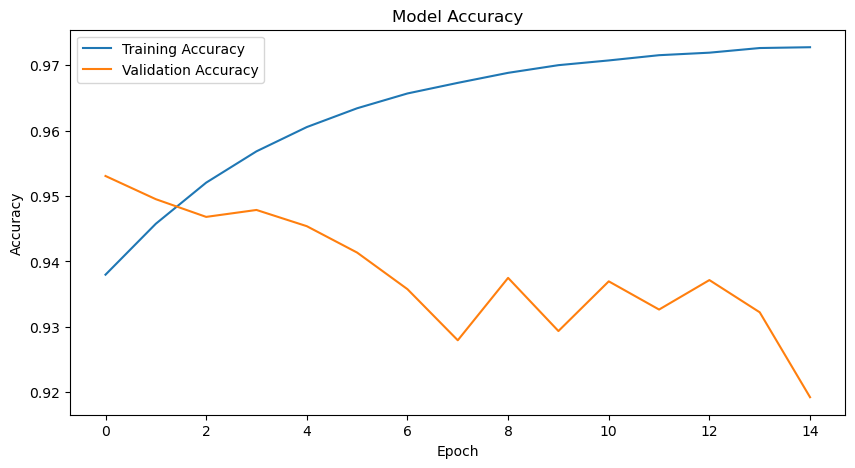

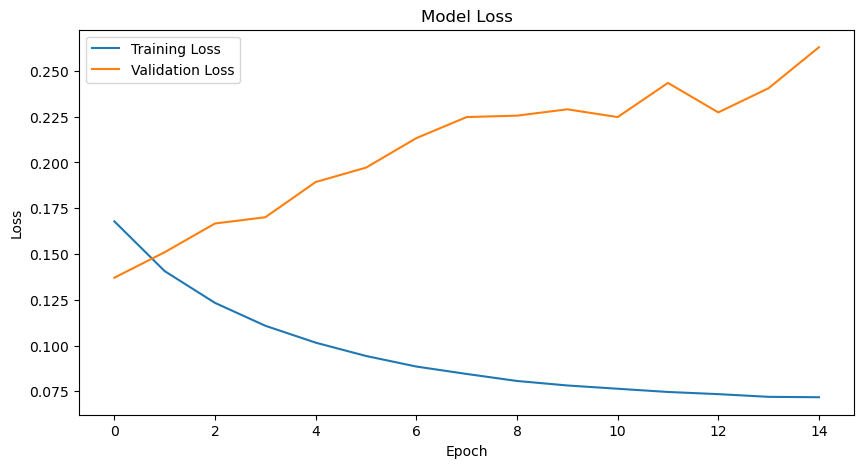

In [5]:
#Step 12: Visualization of plots showing training and validation accuracy/loss curves for window size 40 ms with overlap 10 ms

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [6]:
#Step 13: Evaluate performance using metrics such as F1-score, precision, and recall.

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict labels for the validation set
y_val_pred_probs = model.predict(X_val_scaled)  # Get predicted probabilities
y_val_pred = (y_val_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Calculate evaluation metrics
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Class 0", "Class 1"]))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nAccuracy: {accuracy:.4f}")


26110/26110 [==============================] - 191s 7ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.21      0.26      0.23     39403
     Class 1       0.96      0.95      0.96    796105

    accuracy                           0.92    835508
   macro avg       0.59      0.61      0.60    835508
weighted avg       0.93      0.92      0.92    835508


Confusion Matrix:
[[ 10246  29157]
 [ 38321 757784]]

Accuracy: 0.9192
